In [1]:
from feature_extractor import FeatureExtractor
import sys
import numpy as np
import h5py
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


In [2]:
# Open the HDF5 file
DATA_FOLDER = Path("w:/")
filepath = DATA_FOLDER / "prediction.seg"
file = h5py.File(filepath, 'r')

# Access the dataset
amplitude_pre = file['amplitude/images']
phase_pre = file['phase/images']
label_pre = file['label/ground_truth']
mask = file['mask/images']

In [3]:
# Replace NaN values in phase images with the minimum value of each images
phase = phase_pre[:].copy()
for i, img in enumerate(phase):
    if np.isnan(np.min(img)):
        min = np.nanmin(img)
        img[np.isnan(img)] = min

# Replace NaN values in amplitude images with the minimum value of each images
amplitude = amplitude_pre[:].copy()
for i, img in enumerate(amplitude):
    if np.isnan(np.min(img)):
        min = np.nanmin(img)
        img[np.isnan(img)] = min

# Decode the labels from bytes to strings
label = label_pre[:].copy()
for i in range(len(label)):
    label[i] = label[i].decode('utf-8')

In [4]:
# Create the dataframe with the features
fe = FeatureExtractor(phase, amplitude, mask)

fe.extract_features()

df = fe.features

df['Labels'] = label

df

,Volume,Roundness,Opacity,Amplitude Variance,Amplitude Skewness,Dry Mass Density,Max Phase,Phase Variance,Phase Skewness,DC1,DC2,DC3,Labels
0,192.216887,0.961294,12.440019,0.000404,0.222737,0.148152,3.511719,1.347115,0.151507,0.537326,4.729431,-0.244939,wbc
1,17.202843,1.043580,12.334858,0.000249,-0.321839,0.177625,1.396484,0.134606,0.224105,0.474834,16.368894,-0.117564,plt
2,39.985946,0.987901,12.009360,0.000641,-0.167076,0.156106,1.624023,0.165807,0.210170,0.457755,8.904149,-0.153278,oof
3,1027.158992,0.721094,12.389170,0.000297,-0.096284,0.087903,3.472656,0.955006,-0.100018,0.385540,0.701504,-0.444832,agg
4,170.606705,0.983194,12.231250,0.000968,0.930308,0.123606,2.980469,0.761022,0.251738,0.452567,3.488324,-0.240690,rbc
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,150.418245,0.986904,12.466542,0.000206,0.403621,0.114736,2.093750,0.384657,-0.152236,0.359641,2.367460,-0.232401,wbc
107,17.202843,1.018127,11.425781,0.001215,-0.024194,0.165244,1.778320,0.227547,0.576090,0.511003,19.456771,-0.116086,oof
108,48.528129,0.738422,12.455611,0.000122,0.748587,0.084173,1.414062,0.107143,0.211272,0.439977,9.721542,-0.141061,agg
109,297.234792,0.933343,12.360747,0.000706,1.020639,0.174928,5.105469,2.511811,0.259282,0.617667,4.139719,-0.299315,wbc


In [5]:
# Count the number of rows with NaN values
rows_with_nan = df.isna().any(axis=1).sum()

# Print the result
print("Number of rows with NaN values:", rows_with_nan)

# Iterate over rows and print column names with NaN values
for index, row in df.iterrows():
    nan_columns = row.index[row.isna()].tolist()
    if len(nan_columns) > 0:
        print(f"NaN values in row {index+1} appear in columns: {nan_columns}, label: {df['Labels'][index+1]}")

Number of rows with NaN values: 0


In [6]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Labels"], axis=1), df["Labels"], test_size=0.2, random_state=1111)

In [7]:
# Build the Column Transformer
def col_transf(df):
    num_sc = MinMaxScaler()

    pipe= Pipeline(steps=[("MinMaxScaler", num_sc)])

    pred_column = "Labels"

    # Get a list of all columns except the prediction column
    num_feat = df.columns[df.columns != pred_column]

    ct = ColumnTransformer(transformers=[("NumericalTransformer", pipe, num_feat)])

    return ct


In [8]:
# Build SVC Pipeline and return best estimator based on the grid search
def bestSVC(ct, X_train, y_train):

    pip = Pipeline([
    ('ColumnTransformer', ct),
    ('classifier', SVC(max_iter=1000000, probability=True))
    ])

    gs_param = {
    'classifier__kernel' : ['linear', 'rbf', 'sigmoid'],
    'classifier__C' : [0.3, 0.4, 0.5, 0.7, 1.0],
    'classifier__gamma' : [0.004, 0.005, 0.006, 0.01, 0.05, 0.1 ,0.5]
    } 
    
    stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

    gs = GridSearchCV(pip, gs_param, refit=True, cv=stratified)

    gs.fit(X_train, y_train)

    return gs.best_estimator_

In [9]:
# Build Random Forest Pipeline and return best estimator based on the grid search
def bestRFC(ct, X_train, y_train):

    pipe_rfc = Pipeline([
    ('ColumnTransformer', ct),
    ('classifier', RFC(random_state=12))
    ])

    gs_param_rfc = {
        'classifier__n_estimators' : [10, 20, 50],
        'classifier__max_features' : [2, 4, 8, 12],
        'classifier__max_depth' : [4, 10, 16, 20]
    }
    
    stratified_rfc = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

    gs_rfc = GridSearchCV(pipe_rfc, gs_param_rfc, refit=True, cv=stratified_rfc)

    gs_rfc.fit(X_train, y_train)

    return gs_rfc.best_estimator_

In [10]:
# Return accuracy
def calculate_accuracy(X_train, y_train, X_test, y_test, model):
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    return acc_train, acc_test

# Return balanced accuracy 
def calculate_bal_accuracy(X_train, y_train, X_test, y_test, model):
    y_pred_train = model.predict(X_train)
    bacc_train = balanced_accuracy_score(y_train, y_pred_train)
    y_pred_test = model.predict(X_test)
    bacc_test = balanced_accuracy_score(y_test, y_pred_test)
    return bacc_train, bacc_test

# Return accuracy with class_weights = true
def calculate_accuracy_w(X_train, y_train, X_test, y_test, model):
    model_w = clone(model)
    model_w["classifier"].set_params(class_weight='balanced')
    model_w.fit(X_train, y_train)
    acc_train_w = model_w.score(X_train,y_train)
    acc_test_w = model_w.score(X_test,y_test)
    return acc_train_w, acc_test_w 

# Return balanced accuracy with class_weights = true
def calculate_bal_accuracy_w(X_train, y_train, X_test, y_test, model):
    model_w = clone(model)
    model_w["classifier"].set_params(class_weight='balanced')
    model_w.fit(X_train, y_train)
    y_pred_train = model_w.predict(X_train)
    bacc_train_w = balanced_accuracy_score(y_train, y_pred_train)
    y_pred_test = model_w.predict(X_test)
    bacc_test_w = balanced_accuracy_score(y_test, y_pred_test)
    return bacc_train_w, bacc_test_w 

In [11]:
# Return the classes in the correct order (important for the confusion matrix)
def unique_labels(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_true = y_test

    # Get unique labels from true and predicted labels
    unique_labels = sorted(set(y_true) | set(y_pred))

    # Print the unique labels in the order they appear
    return unique_labels

In [12]:
# Plot confusion matrices for train and test sets
def plot_confusion(model, X_train, y_train, X_test, y_test):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    labels = unique_labels(model, X_test, y_test)

    # Best estimator classifier on training data
    cm_best_train = confusion_matrix(y_train, model.predict(X_train))
    sns.heatmap(cm_best_train, annot=True,fmt='d', ax=axs[0], cmap='Blues', xticklabels=labels, yticklabels=labels)
    axs[0].set_xlabel('Predicted labels');axs[0].set_ylabel('True labels'); 
    axs[0].set_title('Best estimator classifier on training data')

    # Best estimator classifier on test data
    cm_best_test = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm_best_test, annot=True,fmt='d', ax=axs[1], cmap='Blues', xticklabels=labels, yticklabels=labels)
    axs[1].set_xlabel('Predicted labels');axs[1].set_ylabel('True labels'); 
    axs[1].set_title('Best estimator classifier on test data')

In [13]:
ct = col_transf(df)
svc_model = bestSVC(ct, X_train, y_train)

acc_train, acc_test = calculate_accuracy(X_train, y_train, X_test, y_test, svc_model)
bacc_train, bacc_test = calculate_bal_accuracy(X_train, y_train, X_test, y_test, svc_model)
acc_train_w, acc_test_w = calculate_accuracy_w(X_train, y_train, X_test, y_test, svc_model)
bacc_train_w, bacc_test_w = calculate_bal_accuracy_w(X_train, y_train, X_test, y_test, svc_model)

print(f"\nAccuracy on the train set: {acc_train}")
print(f"Accuracy on the test set: {acc_test}")

print(f"\nBalanced Accuracy on the train set best SVC: {bacc_train}")
print(f"Balanced Accuracy on the test set best SVC: {bacc_test}")

print(f"\nAccuracy on the train set (class weights): {acc_train_w}")
print(f"Accuracy on the test (class weights): {acc_test_w}")

print(f"\nBalanced Accuracy on the train set (class weights): {bacc_train_w}")
print(f"Balanced Accuracy on the test set (class weights): {bacc_test_w}")


Accuracy on the train set: 0.9204545454545454
Accuracy on the test set: 0.8695652173913043

Balanced Accuracy on the train set best SVC: 0.8823076923076923
Balanced Accuracy on the test set best SVC: 0.925

Accuracy on the train set (class weights): 0.9545454545454546
Accuracy on the test (class weights): 0.8695652173913043

Balanced Accuracy on the train set (class weights): 0.938974358974359
Balanced Accuracy on the test set (class weights): 0.925


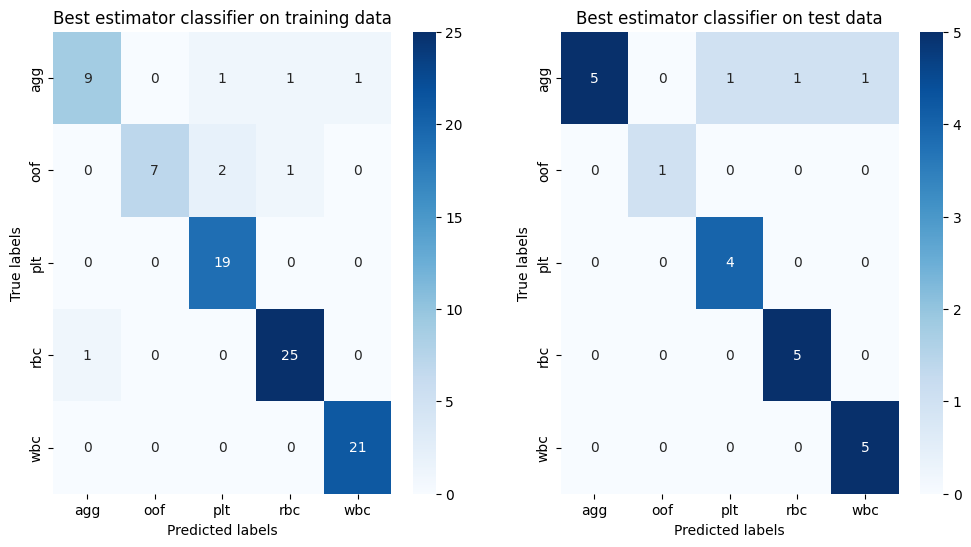

In [14]:
plot_confusion(svc_model, X_train, y_train, X_test, y_test)

In [15]:
# Calculate precision, recall, and F1-score for each class
y_pred = svc_model.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

classes = unique_labels(svc_model, X_test, y_test)

# Print the metrics for each class
for i in range(len(precision)):
    print(f"{classes[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print()

agg
  Precision: 1.0
  Recall: 0.625
  F1-score: 0.7692307692307693

oof
  Precision: 1.0
  Recall: 1.0
  F1-score: 1.0

plt
  Precision: 0.8
  Recall: 1.0
  F1-score: 0.888888888888889

rbc
  Precision: 0.8333333333333334
  Recall: 1.0
  F1-score: 0.9090909090909091

wbc
  Precision: 0.8333333333333334
  Recall: 1.0
  F1-score: 0.9090909090909091



In [16]:
ct = col_transf(df)
rfc_model = bestRFC(ct, X_train, y_train)

acc_train, acc_test = calculate_accuracy(X_train, y_train, X_test, y_test, rfc_model)
bacc_train, bacc_test = calculate_bal_accuracy(X_train, y_train, X_test, y_test, rfc_model)
acc_train_w, acc_test_w = calculate_accuracy_w(X_train, y_train, X_test, y_test, rfc_model)
bacc_train_w, bacc_test_w = calculate_bal_accuracy_w(X_train, y_train, X_test, y_test, rfc_model)

print(f"\nAccuracy on the train set: {acc_train}")
print(f"Accuracy on the test set: {acc_test}")

print(f"\nBalanced Accuracy on the train set best SVC: {bacc_train}")
print(f"Balanced Accuracy on the test set best SVC: {bacc_test}")

print(f"\nAccuracy on the train set (class weights): {acc_train_w}")
print(f"Accuracy on the test (class weights): {acc_test_w}")

print(f"\nBalanced Accuracy on the train set (class weights): {bacc_train_w}")
print(f"Balanced Accuracy on the test set (class weights): {bacc_test_w}")


Accuracy on the train set: 1.0
Accuracy on the test set: 0.8260869565217391

Balanced Accuracy on the train set best SVC: 1.0
Balanced Accuracy on the test set best SVC: 0.9

Accuracy on the train set (class weights): 1.0
Accuracy on the test (class weights): 0.8695652173913043

Balanced Accuracy on the train set (class weights): 1.0
Balanced Accuracy on the test set (class weights): 0.925


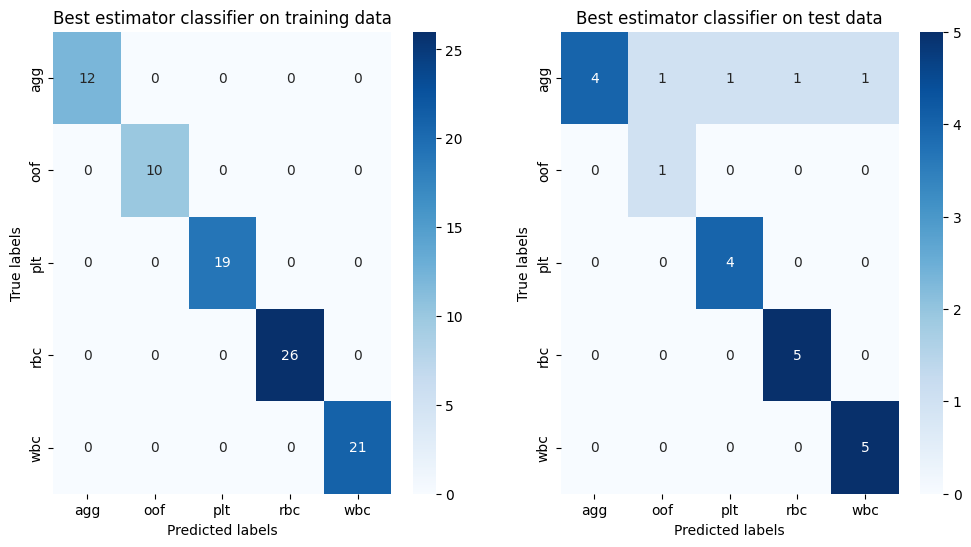

In [17]:
plot_confusion(rfc_model, X_train, y_train, X_test, y_test)

In [18]:
# Calculate precision, recall, and F1-score for each class
y_pred = rfc_model.predict(X_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

classes = unique_labels(rfc_model, X_test, y_test)

# Print the metrics for each class
for i in range(len(precision)):
    print(f"{classes[i]}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1-score: {f1[i]}")
    print()

agg
  Precision: 1.0
  Recall: 0.5
  F1-score: 0.6666666666666666

oof
  Precision: 0.5
  Recall: 1.0
  F1-score: 0.6666666666666666

plt
  Precision: 0.8
  Recall: 1.0
  F1-score: 0.888888888888889

rbc
  Precision: 0.8333333333333334
  Recall: 1.0
  F1-score: 0.9090909090909091

wbc
  Precision: 0.8333333333333334
  Recall: 1.0
  F1-score: 0.9090909090909091

